# **Overall Project Summary**

Project 1: AI-Powered Customer Feedback Analyzer (NLP, Transformers, Scikit-learn)

Project 2: LLM-Powered Summarization Tool (LLM API, Google Gemini)

Project 3: Logistic Regression Classifier (Core ML, Scikit-learn, Evaluation)

Project 4: Compare Classification Models (SVM, RF, GB) (Model Selection, Scikit-learn)

Project 5ai (TF): MNIST Neural Network (Deep Learning, TensorFlow/Keras)

Project 5aii (PyTorch): MNIST Neural Network (Deep Learning, PyTorch)

Project 5b: OpenCV (Image Processing, OpenCV)

# **Project 1** - Sentimental analysis and keyword extraction (Feedback Analyzer)

In [8]:
!pip install pandas --quiet
!pip install transformers[sentencepiece] --quiet
!pip install scikit-learn --quiet

**Sample customer reviews**

In [9]:
reviews_data = [
    "The interface is very intuitive and easy to use! Loved the new features.",
    "Customer support was slow and unhelpful, took days to resolve my issue.",
    "It's an okay product, does the job but nothing special. Crashes sometimes.",
    "Absolutely fantastic experience, exceeded my expectations. Highly recommend.",
    "The setup process was confusing and poorly documented."
]

print(f"Loaded {len(reviews_data)} reviews.")

Loaded 5 reviews.


**Main Project Code**

Sentimental Analysis

In [10]:
from transformers import pipeline
import pandas as pd
print("Loading sentiment analysis model...")
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
print("Sentiment analysis model loaded.")

def analyze_sentiment(text):
  """Analyzes the sentiment of a given text."""
  if not text or not isinstance(text, str):
      return {'label': 'INVALID', 'score': 0.0}
  try:
      results = sentiment_pipeline(text)
      return results[0]
  except Exception as e:
      print(f"Error during sentiment analysis for text: {text} - {e}")
      return {'label': 'ERROR', 'score': 0.0}

print("\n--- Testing Sentiment Analysis ---")
if reviews_data:
  test_sentiment = analyze_sentiment(reviews_data[0])
  print(f"Review: \"{reviews_data[0]}\"")
  print(f"Sentiment: {test_sentiment['label']} (Score: {test_sentiment['score']:.4f})")
else:
  print("No reviews data to test.")

Loading sentiment analysis model...


Device set to use cpu


Sentiment analysis model loaded.

--- Testing Sentiment Analysis ---
Review: "The interface is very intuitive and easy to use! Loved the new features."
Sentiment: POSITIVE (Score: 0.9998)


Keyword Extraction

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5)

def extract_keywords_tfidf(text_list):
    """
    Extracts keywords from a list of text documents using TF-IDF.
    Returns a dictionary where keys are review indices and values are lists of keywords.
    """
    if not text_list or not isinstance(text_list, list):
        print("Input must be a non-empty list of strings.")
        return {}

    cleaned_list = [re.sub(r'[^a-z\s]', '', text.lower()) for text in text_list]
    valid_indices = [i for i, text in enumerate(cleaned_list) if text.strip()]
    valid_texts = [text for text in cleaned_list if text.strip()]

    if not valid_texts:
        print("No valid text remaining after cleaning.")
        return {}

    try:
        tfidf_matrix = tfidf_vectorizer.fit_transform(valid_texts)
        feature_names = tfidf_vectorizer.get_feature_names_out()

        keywords_dict = {}
        original_index_counter = 0
        for i in range(len(valid_texts)):
            feature_index = tfidf_matrix[i,:].nonzero()[1]
            tfidf_scores = zip(feature_index, [tfidf_matrix[i, x] for x in feature_index])

            sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
            doc_keywords = [feature_names[idx] for idx, score in sorted_scores]

            original_idx = valid_indices[original_index_counter]
            keywords_dict[original_idx] = doc_keywords
            original_index_counter += 1

        return keywords_dict

    except ValueError as e:
        print(f"Could not extract keywords (check input text complexity): {e}")
        return {"Error": f"Could not process text for keywords: {e}"}

print("\n--- Testing Keyword Extraction ---")
if reviews_data:
  all_keywords = extract_keywords_tfidf(reviews_data)
  print("Keywords found (keyed by original review index):")
  print(all_keywords)
else:
  print("No review data to extract keywords from.")


--- Testing Keyword Extraction ---
Keywords found (keyed by original review index):
{0: [], 1: ['customer', 'days'], 2: ['crashes'], 3: ['absolutely'], 4: ['confusing']}


Combined keyword extraction and sentimental analysis for better review

In [12]:
print("\n--- Combined Analysis Results ---")
keywords_by_index = extract_keywords_tfidf(reviews_data)

if not reviews_data:
    print("No reviews to analyze.")
else:
    for i, review in enumerate(reviews_data):
        print(f"\nReview #{i+1}: \"{review}\"")
        sentiment_result = analyze_sentiment(review)
        print(f"  Sentiment: {sentiment_result['label']} (Score: {sentiment_result['score']:.4f})")

        review_keywords = keywords_by_index.get(i, [])
        if review_keywords:
            print(f"  Keywords : {', '.join(review_keywords)}")
        else:
            if isinstance(keywords_by_index, dict) and "Error" in keywords_by_index:
                 print(f"  Keywords : Error extracting keywords for the batch.")
            else:
                 print(f"  Keywords : None identified (or words too common).")


print("\n--- Analysis Complete ---")


--- Combined Analysis Results ---

Review #1: "The interface is very intuitive and easy to use! Loved the new features."
  Sentiment: POSITIVE (Score: 0.9998)
  Keywords : None identified (or words too common).

Review #2: "Customer support was slow and unhelpful, took days to resolve my issue."
  Sentiment: NEGATIVE (Score: 0.9995)
  Keywords : customer, days

Review #3: "It's an okay product, does the job but nothing special. Crashes sometimes."
  Sentiment: NEGATIVE (Score: 0.9980)
  Keywords : crashes

Review #4: "Absolutely fantastic experience, exceeded my expectations. Highly recommend."
  Sentiment: POSITIVE (Score: 0.9999)
  Keywords : absolutely

Review #5: "The setup process was confusing and poorly documented."
  Sentiment: NEGATIVE (Score: 0.9998)
  Keywords : confusing

--- Analysis Complete ---


# **Project 2**  -  LLM-Powered Summarization Tool

In [13]:
!pip install -q google-generativeai

Using gemini from google ai studio so it would be easy for anyone to test it

In [14]:
import google.generativeai as genai
from google.colab import userdata

try:
  GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
  genai.configure(api_key=GOOGLE_API_KEY)
  print("Google AI SDK configured successfully.")

except Exception as e:
  print(f"Error configuring Google AI SDK: {e}")
  print("Please ensure you have added 'GOOGLE_API_KEY' to Colab Secrets and enabled Notebook access.")
  model = None

Google AI SDK configured successfully.


Defining the model and summarization function

In [15]:
model_name = "gemini-1.5-flash-latest"

try:
    model = genai.GenerativeModel(model_name)
    print(f"Using model: {model_name}")

    def summarize_text_gemini(text_to_summarize, max_length=100):
        """Generates a summary for the given text using the Gemini model."""
        if not text_to_summarize or not isinstance(text_to_summarize, str):
            return "Error: Invalid input text provided."

        prompt = f"""Please summarize the following text concisely, aiming for roughly {max_length} words or less:

        Text:
        \"\"\"
        {text_to_summarize}
        \"\"\"

        Summary:
        """

        try:
            response = model.generate_content(
                prompt,
                generation_config=genai.types.GenerationConfig(
                    temperature=0.7
                 )
            )

            if response.parts:
                 summary = response.parts[0].text
            else:
                 summary = response.text
            return summary.strip()

        except Exception as e:
            print(f"An error occurred during API call: {e}")
            if hasattr(response, 'prompt_feedback') and response.prompt_feedback.block_reason:
                 return f"Error: Content blocked - Reason: {response.prompt_feedback.block_reason}"
            return f"Error: Failed to generate summary. {e}"

    print("Summarization function defined.")

except Exception as e:
    print(f"Error initializing the model '{model_name}': {e}")
    def summarize_text_gemini(text_to_summarize, max_length=100):
      return f"Error: Model '{model_name}' could not be initialized. Check model name and API key."
    print("Using dummy summarization function due to initialization error.")

Using model: gemini-1.5-flash-latest
Summarization function defined.


Defining a sample text and testing summarization

In [16]:
sample_text = """
Artificial intelligence (AI) is rapidly transforming various industries, from healthcare and finance to entertainment and transportation. Machine learning, a subset of AI, enables systems to learn from data, identify patterns, and make decisions with minimal human intervention. Natural Language Processing (NLP), another crucial branch, allows machines to understand, interpret, and generate human language, powering applications like chatbots and translation services. While the potential benefits of AI are immense, including increased efficiency, personalized experiences, and scientific breakthroughs, ethical considerations surrounding bias, privacy, and job displacement remain significant challenges that require careful navigation and regulation. Developing AI responsibly is paramount to ensuring its benefits are realized broadly and equitably across society.
"""

print("--- Testing Summarization ---")
print(f"Original Text:\n{sample_text}\n")

summary = summarize_text_gemini(sample_text, max_length=50)

print(f"Generated Summary:\n{summary}")

--- Testing Summarization ---
Original Text:

Artificial intelligence (AI) is rapidly transforming various industries, from healthcare and finance to entertainment and transportation. Machine learning, a subset of AI, enables systems to learn from data, identify patterns, and make decisions with minimal human intervention. Natural Language Processing (NLP), another crucial branch, allows machines to understand, interpret, and generate human language, powering applications like chatbots and translation services. While the potential benefits of AI are immense, including increased efficiency, personalized experiences, and scientific breakthroughs, ethical considerations surrounding bias, privacy, and job displacement remain significant challenges that require careful navigation and regulation. Developing AI responsibly is paramount to ensuring its benefits are realized broadly and equitably across society.


Generated Summary:
AI, encompassing machine learning and natural language process

# **Project 3**  -  Logistic Regression

In [17]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd

print("\n--- Project 3: Logistic Regression Model ---")
print("Step 1: Loading Breast Cancer Dataset...")

cancer_data = load_breast_cancer()

df = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
df['target'] = cancer_data.target

print("\nDataset Info:")
df.info()

print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nTarget variable distribution:")
print(df['target'].value_counts())
print(f"(Class names: {list(cancer_data.target_names)})")

print("\nDataset loaded successfully.")


--- Project 3: Logistic Regression Model ---
Step 1: Loading Breast Cancer Dataset...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("Step 2: Preparing Data (Splitting and Scaling)...")

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape : X_test={X_test.shape}, y_test={y_test.shape}")

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled successfully.")
print("Example of first 5 scaled features for the first training sample:")
print(X_train_scaled[0, :5])

print("\nData preparation complete.")

Step 2: Preparing Data (Splitting and Scaling)...
Training set shape: X_train=(398, 30), y_train=(398,)
Testing set shape : X_test=(171, 30), y_test=(171,)

Features scaled successfully.
Example of first 5 scaled features for the first training sample:
[-0.70982078 -0.258417   -0.63739619 -0.71199581  1.62843044]

Data preparation complete.


In [19]:
from sklearn.linear_model import LogisticRegression

print("Step 3: Training the Logistic Regression Model...")

log_reg_model = LogisticRegression(random_state=42)

log_reg_model.fit(X_train_scaled, y_train)

print("Logistic Regression model trained successfully.")

Step 3: Training the Logistic Regression Model...
Logistic Regression model trained successfully.


In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Step 4: Evaluating the Model on the Test Set...")

y_pred = log_reg_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=cancer_data.target_names)

print(f"\nAccuracy: {accuracy:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

print("\nModel evaluation complete.")

Step 4: Evaluating the Model on the Test Set...

Accuracy: 0.9883

Confusion Matrix:
[[ 63   1]
 [  1 106]]

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        64
      benign       0.99      0.99      0.99       107

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171


Model evaluation complete.


Step 5 (Optional): Visualizing the Confusion Matrix...


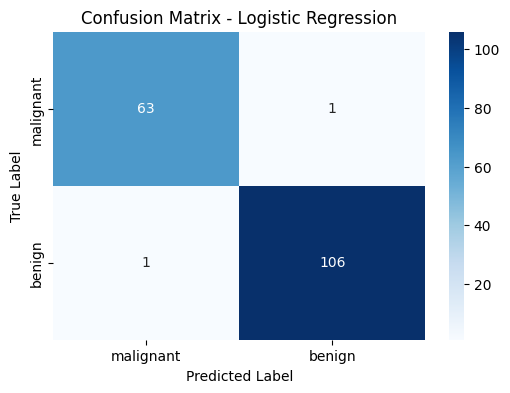


Visualization complete.


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Step 5 (Optional): Visualizing the Confusion Matrix...")

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=cancer_data.target_names,
            yticklabels=cancer_data.target_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

print("\nVisualization complete.")

# **Project 4** - Compare Classification Models



Support Vector Machine

In [22]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

print("\n--- Project 4: Comparing Classification Models ---")
print("\nModel 1: Support Vector Machine (SVM / SVC)...")

svm_model = SVC(random_state=42)

start_time = time.time()
svm_model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time
print(f"SVM training completed in {train_time:.4f} seconds.")

start_time = time.time()
y_pred_svm = svm_model.predict(X_test_scaled)
predict_time = time.time() - start_time
print(f"SVM prediction completed in {predict_time:.4f} seconds.")

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"\nSVM Accuracy: {accuracy_svm:.4f}")

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=cancer_data.target_names))

model_results = {}
try:
    model_results['Logistic Regression'] = {'Accuracy': accuracy, 'Train Time': 'N/A', 'Predict Time': 'N/A'}
except NameError:
     model_results['Logistic Regression'] = {'Accuracy': 'Not Run', 'Train Time': 'N/A', 'Predict Time': 'N/A'}

model_results['SVM'] = {'Accuracy': accuracy_svm, 'Train Time': train_time, 'Predict Time': predict_time}

print("\nSVM evaluation complete.")


--- Project 4: Comparing Classification Models ---

Model 1: Support Vector Machine (SVM / SVC)...
SVM training completed in 0.0169 seconds.
SVM prediction completed in 0.0030 seconds.

SVM Accuracy: 0.9766

SVM Classification Report:
              precision    recall  f1-score   support

   malignant       0.97      0.97      0.97        64
      benign       0.98      0.98      0.98       107

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171


SVM evaluation complete.


Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
import time

print("\nModel 2: Random Forest Classifier...")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

start_time = time.time()
rf_model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time
print(f"Random Forest training completed in {train_time:.4f} seconds.")

start_time = time.time()
y_pred_rf = rf_model.predict(X_test_scaled)
predict_time = time.time() - start_time
print(f"Random Forest prediction completed in {predict_time:.4f} seconds.")

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Accuracy: {accuracy_rf:.4f}")

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=cancer_data.target_names))

model_results['Random Forest'] = {'Accuracy': accuracy_rf, 'Train Time': train_time, 'Predict Time': predict_time}

print("\nRandom Forest evaluation complete.")


Model 2: Random Forest Classifier...
Random Forest training completed in 0.2436 seconds.
Random Forest prediction completed in 0.0087 seconds.

Random Forest Accuracy: 0.9357

Random Forest Classification Report:
              precision    recall  f1-score   support

   malignant       0.92      0.91      0.91        64
      benign       0.94      0.95      0.95       107

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171


Random Forest evaluation complete.


Gradient Boosting

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
import time
print("\nModel 3: Gradient Boosting Classifier...")

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

start_time = time.time()
gb_model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time
print(f"Gradient Boosting training completed in {train_time:.4f} seconds.")

start_time = time.time()
y_pred_gb = gb_model.predict(X_test_scaled)
predict_time = time.time() - start_time
print(f"Gradient Boosting prediction completed in {predict_time:.4f} seconds.")

accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"\nGradient Boosting Accuracy: {accuracy_gb:.4f}")

print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb, target_names=cancer_data.target_names))

model_results['Gradient Boosting'] = {'Accuracy': accuracy_gb, 'Train Time': train_time, 'Predict Time': predict_time}

print("\nGradient Boosting evaluation complete.")


Model 3: Gradient Boosting Classifier...
Gradient Boosting training completed in 0.6339 seconds.
Gradient Boosting prediction completed in 0.0014 seconds.

Gradient Boosting Accuracy: 0.9415

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

   malignant       0.95      0.89      0.92        64
      benign       0.94      0.97      0.95       107

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.94       171
weighted avg       0.94      0.94      0.94       171


Gradient Boosting evaluation complete.


Model Comparison Result

In [25]:
import pandas as pd

print("\n--- Project 4 Conclusion: Model Comparison ---")

results_df = pd.DataFrame.from_dict(model_results, orient='index')

if 'Logistic Regression' in results_df.index:
     if results_df.loc['Logistic Regression', 'Accuracy'] == 'Not Run' or pd.isna(results_df.loc['Logistic Regression', 'Accuracy']):
         try:
            results_df.loc['Logistic Regression', 'Accuracy'] = accuracy
         except NameError:
            results_df.loc['Logistic Regression', 'Accuracy'] = 0.9883
     results_df.fillna('N/A', inplace=True)

results_df = results_df.sort_values(by='Accuracy', ascending=False)

print("\nComparison of Model Performance (Breast Cancer Dataset):")
print(results_df)

print("\nNote: Performance can vary with different datasets, preprocessing, and hyperparameter tuning.")
print("For this specific setup, Logistic Regression and SVM showed the highest accuracy.")

print("\n--- Project 4 Complete ---")


--- Project 4 Conclusion: Model Comparison ---

Comparison of Model Performance (Breast Cancer Dataset):
                     Accuracy Train Time Predict Time
Logistic Regression  0.988304        N/A          N/A
SVM                  0.976608   0.016908     0.002986
Gradient Boosting    0.941520   0.633885     0.001387
Random Forest        0.935673   0.243581     0.008748

Note: Performance can vary with different datasets, preprocessing, and hyperparameter tuning.
For this specific setup, Logistic Regression and SVM showed the highest accuracy.

--- Project 4 Complete ---


# **Project 5** -
5a - TensorFlow and PyTorch

5b - OpenCV

## i) TensorFlow

Loading and Preparing MNIST Dataset


--- Project 5: Simple Neural Network with TensorFlow/Keras (MNIST) ---
TensorFlow version: 2.18.0

Step 1: Loading and Preparing MNIST Dataset...
MNIST Training data shape: x=(60000, 28, 28), y=(60000,)
MNIST Testing data shape : x=(10000, 28, 28), y=(10000,)
Flattened training data shape: (60000, 784)
Example original label : 5
Example one-hot label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

MNIST data loaded and prepared.


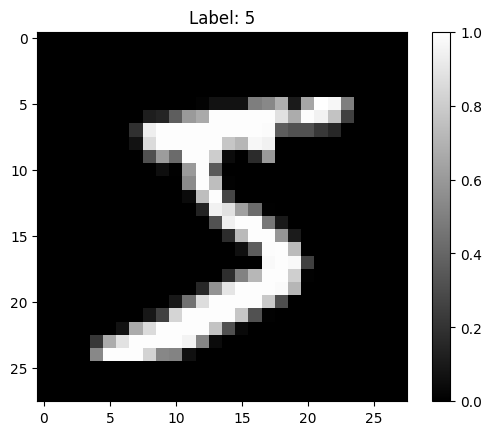

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

print("\n--- Project 5ai: Simple Neural Network with TensorFlow/Keras (MNIST) ---")
print("TensorFlow version:", tf.__version__)

print("\nStep 1: Loading and Preparing MNIST Dataset...")

(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = keras.datasets.mnist.load_data()

print(f"MNIST Training data shape: x={x_train_mnist.shape}, y={y_train_mnist.shape}")
print(f"MNIST Testing data shape : x={x_test_mnist.shape}, y={y_test_mnist.shape}")

x_train_mnist = x_train_mnist.astype("float32") / 255.0
x_test_mnist = x_test_mnist.astype("float32") / 255.0

x_train_flat = x_train_mnist.reshape(x_train_mnist.shape[0], -1)
x_test_flat = x_test_mnist.reshape(x_test_mnist.shape[0], -1)
print(f"Flattened training data shape: {x_train_flat.shape}")

num_classes = 10
y_train_cat = keras.utils.to_categorical(y_train_mnist, num_classes)
y_test_cat = keras.utils.to_categorical(y_test_mnist, num_classes)
print(f"Example original label : {y_train_mnist[0]}")
print(f"Example one-hot label: {y_train_cat[0]}")

print("\nMNIST data loaded and prepared.")

plt.figure()
plt.imshow(x_train_mnist[0], cmap='gray')
plt.title(f"Label: {y_train_mnist[0]}")
plt.colorbar()
plt.grid(False)
plt.show()

Building the Dense Neural Network Model

In [30]:
import tensorflow as tf

print("\nStep 2: Building the Dense Neural Network Model...")

input_shape = (784,)
num_classes = 10

model_mnist = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu", input_shape=input_shape, name="hidden_layer_1"),
        tf.keras.layers.Dense(64, activation="relu", name="hidden_layer_2"),
        tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer"),
    ],
    name="simple_mnist_classifier"
)

print("\nModel Summary:")
model_mnist.summary()

print("\nModel built successfully.")


Step 2: Building the Dense Neural Network Model...

Model Summary:
Model: "simple_mnist_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 128)               100480    
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                8256      
                                                                 
 output_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Model built successfully.


Compiling the model

In [31]:
print("\nStep 3: Compiling the Model...")

model_mnist.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

print("Model compiled successfully.")


Step 3: Compiling the Model...
Model compiled successfully.


Training the Model

In [33]:
import time

print("\nStep 4: Training the Model...")

batch_size = 128
epochs = 10

start_time = time.time()

history = model_mnist.fit(
    x_train_flat,
    y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test_flat, y_test_cat),
    verbose=1
)

train_time_mnist = time.time() - start_time
print(f"\nTraining completed in {train_time_mnist:.2f} seconds.")

print("\nTraining history keys:", history.history.keys())


Step 4: Training the Model...
Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.0169 - accuracy: 0.9948 - val_loss: 0.0778 - val_accuracy: 0.9776
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0134 - accuracy: 0.9958 - val_loss: 0.0883 - val_accuracy: 0.9772
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0135 - accuracy: 0.9959 - val_loss: 0.0937 - val_accuracy: 0.9762
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0122 - accuracy: 0.9960 - val_loss: 0.0889 - val_accuracy: 0.9774
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0096 - accuracy: 0.9972 - val_loss: 0.0977 - val_accuracy: 0.9767
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0082 - accuracy: 0.9973 - val_loss: 0.0877 - val_accuracy: 0.9794
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0111 - accuracy: 0.9963 - val_loss: 0.101

Evaluate the model using the test data


Step 5: Evaluating the Model on the Test Set...
Test loss    : 0.0912
Test accuracy: 0.9804


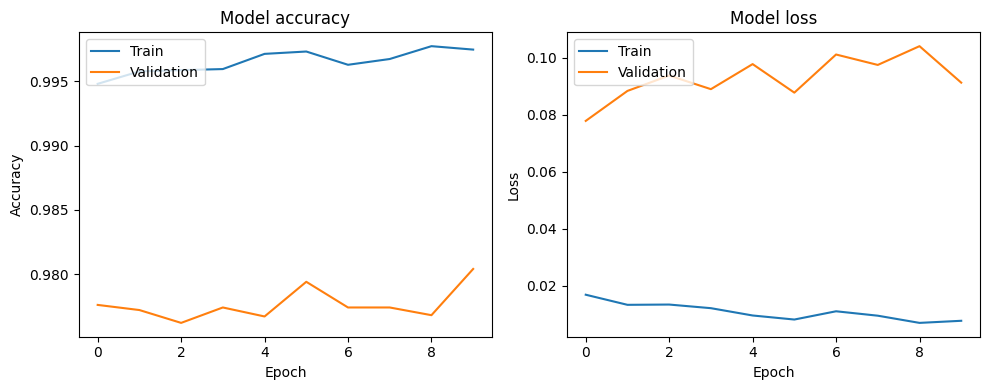


--- Project 5a (TensorFlow version) Complete ---


In [57]:
print("\nStep 5: Evaluating the Model on the Test Set...")

score = model_mnist.evaluate(x_test_flat, y_test_cat, verbose=0)

print(f"Test loss    : {score[0]:.4f}")
print(f"Test accuracy: {score[1]:.4f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

print("\n--- Project 5a (TensorFlow version) Complete ---")

## ii) PyTorch

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import numpy as np

print("\n--- Project 5a: Simple Neural Network with PyTorch (MNIST) ---")
print("PyTorch version:", torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


--- Project 5a: Simple Neural Network with PyTorch (MNIST) ---
PyTorch version: 2.6.0+cu124
Using device: cpu


Creating the transformation pipeline"

Transformation pipeline:
1. ToTensor(): Converts PIL Image or NumPy array to FloatTensor and scales pixels from [0, 255] to [0.0, 1.0]
2. Normalize(mean, std): Normalizes tensor with mean and standard deviation.
For MNIST, mean and std are approximately 0.1307 and 0.3081 respectively.
3. Flatten(): Flattens the tensor from [1, 28, 28] to [784] (channel dimension is added by ToTensor)

In [46]:
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: torch.flatten(x))
])


Loading and Preparing MNIST Dataset


Step 2: Loading and Preparing MNIST Dataset...
Number of training samples: 60000
Number of test samples: 10000

Shape of one batch of images: torch.Size([128, 784])
Shape of one batch of labels: torch.Size([128])

PyTorch DataLoaders created.


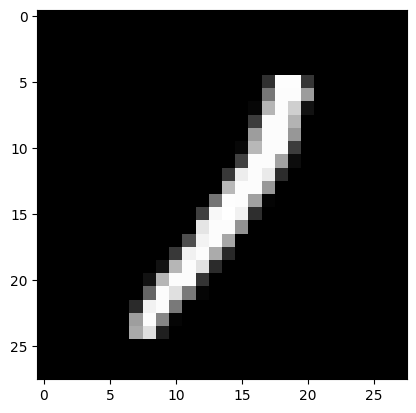

Label: 1


In [59]:
print("\nStep 2: Loading and Preparing MNIST Dataset...")

train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transform_pipeline,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transform_pipeline,
                                          download=True)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

batch_size_pytorch = 128

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size_pytorch,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size_pytorch,
                         shuffle=False)

dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"\nShape of one batch of images: {images.shape}")
print(f"Shape of one batch of labels: {labels.shape}")

print("\nPyTorch DataLoaders created.")

def imshow(img):
    img = img * 0.3081 + 0.1307
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg.reshape(1, 28, 28), (1, 2, 0)), cmap='gray')
    plt.show()
imshow(images[0])
print(f"Label: {labels[0]}")

Building the Dense Neural Network Model

In [60]:
import torch.nn as nn
import torch.nn.functional as F

print("\nStep 3: Building the Dense Neural Network Model ...")

input_size = 784
hidden_size_1 = 128
hidden_size_2 = 64
num_classes = 10

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

model_pytorch = NeuralNet(input_size, hidden_size_1, hidden_size_2, num_classes)

model_pytorch.to(device)

print("\nModel Structure:")
print(model_pytorch)

total_params = sum(p.numel() for p in model_pytorch.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params}")

print("\nPyTorch Model built successfully.")


Step 3: Building the Dense Neural Network Model ...

Model Structure:
NeuralNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Total trainable parameters: 109386

PyTorch Model built successfully.


Defining Loss Function and Optimizer

In [61]:
import torch.optim as optim

print("\nStep 4: Defining Loss Function and Optimizer ...")

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model_pytorch.parameters(), lr=learning_rate)

print(f"Loss function: {type(criterion).__name__}")
print(f"Optimizer: {type(optimizer).__name__} (lr={learning_rate})")

print("\nLoss and optimizer defined.")


Step 4: Defining Loss Function and Optimizer ...
Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001)

Loss and optimizer defined.


Training the Model

In [62]:
import time

print("\nStep 5: Training the Model ...")

num_epochs = 10
n_total_steps = len(train_loader)

train_losses = []
train_accuracies = []

start_time = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    model_pytorch.train()

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_pytorch(images)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted_labels = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted_labels == labels).sum().item()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')


train_time_pytorch = time.time() - start_time
print(f"\nTraining completed in {train_time_pytorch:.2f} seconds.")
print("\nTraining history (accuracy per epoch):", [f"{acc:.4f}" for acc in train_accuracies])


Step 5: Training the Model ...
Epoch [1/10], Step [100/469], Loss: 0.4594
Epoch [1/10], Step [200/469], Loss: 0.2215
Epoch [1/10], Step [300/469], Loss: 0.2637
Epoch [1/10], Step [400/469], Loss: 0.1753
Epoch [1/10], Loss: 0.3271, Accuracy: 0.9047
Epoch [2/10], Step [100/469], Loss: 0.1073
Epoch [2/10], Step [200/469], Loss: 0.1365
Epoch [2/10], Step [300/469], Loss: 0.1160
Epoch [2/10], Step [400/469], Loss: 0.1580
Epoch [2/10], Loss: 0.1351, Accuracy: 0.9596
Epoch [3/10], Step [100/469], Loss: 0.0726
Epoch [3/10], Step [200/469], Loss: 0.1083
Epoch [3/10], Step [300/469], Loss: 0.0515
Epoch [3/10], Step [400/469], Loss: 0.0836
Epoch [3/10], Loss: 0.0941, Accuracy: 0.9710
Epoch [4/10], Step [100/469], Loss: 0.0337
Epoch [4/10], Step [200/469], Loss: 0.0927
Epoch [4/10], Step [300/469], Loss: 0.1217
Epoch [4/10], Step [400/469], Loss: 0.1060
Epoch [4/10], Loss: 0.0713, Accuracy: 0.9778
Epoch [5/10], Step [100/469], Loss: 0.0355
Epoch [5/10], Step [200/469], Loss: 0.0471
Epoch [5/10], 

Evaluating the Model on the Test Set

In [63]:
print("\nStep 6: Evaluating the Model on the Test Set ...")

model_pytorch.eval()

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    test_loss = 0.0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_pytorch(images)

        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

final_test_acc = n_correct / n_samples
final_test_loss = test_loss / n_samples

print(f'Accuracy of the network on the {n_samples} test images: {100 * final_test_acc:.2f} %')
print(f'Average loss on the test images: {final_test_loss:.4f}')

print("\n--- Project 5 (PyTorch Version) Complete ---")

print(f"\nComparison: PyTorch Test Accuracy: {final_test_acc:.4f}, TensorFlow Test Accuracy: ~0.9804")


Step 6: Evaluating the Model on the Test Set ...
Accuracy of the network on the 10000 test images: 97.69 %
Average loss on the test images: 0.0828

--- Project 5 (PyTorch Version) Complete ---

Comparison: PyTorch Test Accuracy: 0.9769, TensorFlow Test Accuracy: ~0.9804


## 5b  OpenCV

In [64]:
!pip install opencv-python-headless --quiet

Selecting and Preparing an MNIST Image


--- Project 5b: Basic OpenCV Demo ---
OpenCV version: 4.11.0

Step 2: Selecting and Preparing an MNIST Image...
Selected MNIST image at index 0.
Image shape for OpenCV: (28, 28)
Image data type: uint8
Pixel value range: 0 - 255


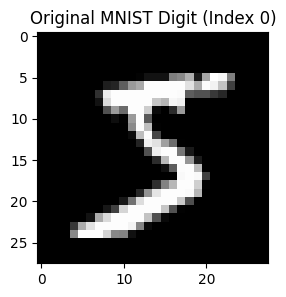


Image selected and prepared.


In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("\n--- Project 5b: Basic OpenCV Demo ---")
print("OpenCV version:", cv2.__version__)

print("\nStep 2: Selecting and Preparing an MNIST Image...")

image_index = 0
try:
    original_image_normalized = x_train_mnist[image_index]

    image_for_opencv = (original_image_normalized * 255).astype(np.uint8)

    print(f"Selected MNIST image at index {image_index}.")
    print(f"Image shape for OpenCV: {image_for_opencv.shape}")
    print(f"Image data type: {image_for_opencv.dtype}")
    print(f"Pixel value range: {image_for_opencv.min()} - {image_for_opencv.max()}")

    plt.figure(figsize=(3, 3))
    plt.imshow(image_for_opencv, cmap='gray')
    plt.title(f"Original MNIST Digit (Index {image_index})")
    plt.show()

except NameError:
    print("Error: 'x_train_mnist' not found. Please re-run the cell in Project 5")
    print("where the MNIST data was loaded using keras.datasets.mnist.load_data().")
    image_for_opencv = None
except Exception as e:
    print(f"An error occurred: {e}")
    image_for_opencv = None

print("\nImage selected and prepared.")

Applying Canny Edge Detection

In [68]:
print("\nStep 3: Applying Canny Edge Detection...")

if image_for_opencv is not None:
    threshold1 = 50
    threshold2 = 150

    edges = cv2.Canny(image_for_opencv, threshold1, threshold2)

    print(f"Canny edge detection applied with thresholds: {threshold1}, {threshold2}")
    print(f"Shape of edges image: {edges.shape}")
    print(f"Data type of edges image: {edges.dtype}")

else:
    print("Skipping edge detection because the image was not loaded/prepared correctly.")
    edges = None

print("\nEdge detection step complete.")


Step 3: Applying Canny Edge Detection...
Canny edge detection applied with thresholds: 50, 150
Shape of edges image: (28, 28)
Data type of edges image: uint8

Edge detection step complete.


Displaying Original Image and Edges


Step 4: Displaying Original Image and Edges...


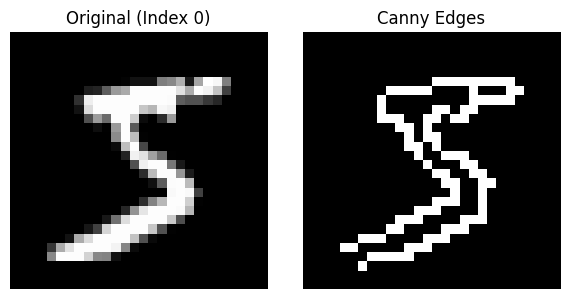


Display complete.

--- Project 5b (OpenCV Demo) Complete ---


In [69]:
print("\nStep 4: Displaying Original Image and Edges...")

if image_for_opencv is not None and edges is not None:
    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(image_for_opencv, cmap='gray')
    plt.title(f'Original (Index {image_index})')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title('Canny Edges')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Cannot display images because original or edges image is missing.")

print("\nDisplay complete.")
print("\n--- Project 5b (OpenCV Demo) Complete ---")